<a href="https://colab.research.google.com/github/AndrewKruszka/NeuralMachineLearning/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Andrew Kruszka

In this project we aim to analyze spike train data from the hippocampal region of rats to see whether the firing patterns of neurons can be modeled as a Poisson process

To start, we'll gather and download three files from githu containing the neuron information. Once the files are downloaded correctly, there should be a success message

In [1]:
import os

# Define GitHub raw file links
github_files = {
    "Neuron 1 (ec012ec.187.res.1)": "https://raw.githubusercontent.com/AndrewKruszka/NeuralMachineLearning/main/BuszakiLab-MizusekiK-hc3/ec012/ec012ec.187.res.1",
    "Neuron 2 (ec012ec.375.res.1)": "https://raw.githubusercontent.com/AndrewKruszka/NeuralMachineLearning/main/BuszakiLab-MizusekiK-hc3/ec012/ec012ec.375.res.1",
    "Neuron 3 (ec016.457.res.2)": "https://raw.githubusercontent.com/AndrewKruszka/NeuralMachineLearning/main/BuszakiLab-MizusekiK-hc3/ec016/ec016.457.res.2"
}

# Download files into Colab
local_files = {}
for neuron, url in github_files.items():
    filename = url.split("/")[-1]  # Extract filename from URL
    os.system(f"wget -q {url} -O {filename}")  # Download file quietly
    local_files[neuron] = filename  # Store local filename for later use

print("Files downloaded successfully.")



Files downloaded successfully.


Next, we will set the time step as 0.05 ms since the sampling rate is 20kHz. We will then multiply each index by this value

Each file wil be passed into pandas, processed, and the processed spike time stored in the dictionary spike_data

The total number of spikes for each nueron is also printed

In [2]:
import pandas as pd

# Sampling rate: 20 kHz → Each time step = 0.05 ms
time_step_ms = 0.05

# Load the data and convert spike times to milliseconds
spike_data = {}
for neuron, path in local_files.items():
    spike_times = pd.read_csv(path, header=None, names=["Time Index"])  # Load data as a single-column DataFrame
    spike_times["Time (ms)"] = spike_times["Time Index"] * time_step_ms  # Convert time index to milliseconds
    spike_data[neuron] = spike_times  # Store in dictionary

    print(f"Loaded {neuron} with {len(spike_times)} spikes.")


Loaded Neuron 1 (ec012ec.187.res.1) with 89148 spikes.
Loaded Neuron 2 (ec012ec.375.res.1) with 77870 spikes.
Loaded Neuron 3 (ec016.457.res.2) with 298437 spikes.


Then, we will loop through the dictionary and extract:
1. The total number of spikes recorded
2. The start and end times of the spikes in miliseconds
3. The total duration of the recording for each rat

This information is the displayed in a table using Pandas

In [5]:
import pandas as pd
from IPython.display import display  # For better table display in Colab

# Summary statistics
summary_stats = {
    "Neuron": [],
    "Total Spikes": [],
    "Start Time (ms)": [],
    "End Time (ms)": [],
    "Duration (s)": []
}

for neuron, df in spike_data.items():
    summary_stats["Neuron"].append(neuron)
    summary_stats["Total Spikes"].append(len(df))
    summary_stats["Start Time (ms)"].append(df["Time (ms)"].min())  # First spike time
    summary_stats["End Time (ms)"].append(df["Time (ms)"].max())  # Last spike time
    summary_stats["Duration (s)"].append((df["Time (ms)"].max() - df["Time (ms)"].min()) / 1000)  # Convert ms to seconds

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary_stats)

# Display summary as a table
display(summary_df)  # This will render a nice table in Colab




,Neuron,Total Spikes,Start Time (ms),End Time (ms),Duration (s)
0,Neuron 1 (ec012ec.187.res.1),89148,6.80,1096396.65,1096.38985
1,Neuron 2 (ec012ec.375.res.1),77870,2.45,631190.25,631.18780
2,Neuron 3 (ec016.457.res.2),298437,2.10,2751244.25,2751.24215


Next, we need to divide the total recording time into equal time windows so that we can count how many spikes fall into each window

In [6]:
import numpy as np

def count_spikes_in_windows(spike_times, window_size_ms):
    """
    Counts the number of spikes in fixed time windows.

    Parameters:
    - spike_times (array): Spike times in milliseconds.
    - window_size_ms (float): Size of time window in milliseconds.

    Returns:
    - spike_counts (array): Number of spikes per time window.
    """
    max_time = spike_times.max()  # Last spike time
    num_windows = int(np.ceil(max_time / window_size_ms))  # Number of windows
    spike_counts = np.zeros(num_windows)  # Initialize array for spike counts

    # Count spikes in each window
    for time in spike_times:
        window_index = int(time // window_size_ms)  # Assign spike to a window
        spike_counts[window_index] += 1  # Increment count

    return spike_counts

# Select a time window size (change to test different sizes)
window_size = 50  # in milliseconds

# Compute spike counts for each neuron
spike_counts_per_neuron = {}
for neuron, df in spike_data.items():
    spike_counts_per_neuron[neuron] = count_spikes_in_windows(df["Time (ms)"], window_size)

# Show a few spike count samples
for neuron, counts in spike_counts_per_neuron.items():
    print(f"Spike counts (first 10) for {neuron}: {counts[:10]}")


Spike counts (first 10) for Neuron 1 (ec012ec.187.res.1): [3. 3. 3. 5. 4. 4. 4. 4. 8. 3.]
Spike counts (first 10) for Neuron 2 (ec012ec.375.res.1): [ 8.  2.  7.  3.  5.  7. 11. 13. 11. 12.]
Spike counts (first 10) for Neuron 3 (ec016.457.res.2): [13. 10.  8. 10. 14.  6.  8.  5.  6.  9.]


Then we estimate lambda using the mean spike count per window



In [7]:
from scipy.stats import poisson

def fit_poisson_mle(spike_counts):
    """
    Fits a Poisson distribution using Maximum Likelihood Estimation (MLE).

    Parameters:
    - spike_counts (array): Number of spikes per time window.

    Returns:
    - lambda_hat (float): Estimated Poisson rate parameter (mean spike count per window).
    """
    lambda_hat = np.mean(spike_counts)  # Poisson MLE estimate (mean count)
    return lambda_hat

# Compute MLE Poisson parameter for each neuron
poisson_params = {}
for neuron, counts in spike_counts_per_neuron.items():
    poisson_params[neuron] = fit_poisson_mle(counts)

# Print estimated Poisson parameters
for neuron, lambda_hat in poisson_params.items():
    print(f"Estimated lambda (Poisson rate) for {neuron}: {lambda_hat:.2f}")


Estimated lambda (Poisson rate) for Neuron 1 (ec012ec.187.res.1): 4.07
Estimated lambda (Poisson rate) for Neuron 2 (ec012ec.375.res.1): 6.17
Estimated lambda (Poisson rate) for Neuron 3 (ec016.457.res.2): 5.42


Next, we calculate the Fano factor (variance/mean)

For a perfect Poisson, the Fano factor should be ~1

If it's >1, then the variance is larger than expected for a Poisson, and if it's < 1, then the spikes are more regular than a Poisson distribution

In [9]:
def compute_fano_factor(spike_counts):
    """
    Computes the Fano Factor (Variance / Mean) to check Poisson behavior.

    Parameters:
    - spike_counts (array): Number of spikes per time window.

    Returns:
    - fano_factor (float): Computed Fano factor.
    """
    variance = np.var(spike_counts)  # Compute variance
    mean = np.mean(spike_counts)  # Compute mean
    fano_factor = variance / mean if mean > 0 else np.nan  # Avoid division by zero
    return fano_factor

# Compute Fano factors for each neuron
fano_factors = {}
for neuron, counts in spike_counts_per_neuron.items():
    fano_factors[neuron] = compute_fano_factor(counts)

# Print Fano factors
for neuron, fano in fano_factors.items():
    print(f"Fano Factor for {neuron}: {fano:.2f}")


Fano Factor for Neuron 1 (ec012ec.187.res.1): 1.20
Fano Factor for Neuron 2 (ec012ec.375.res.1): 1.75
Fano Factor for Neuron 3 (ec016.457.res.2): 3.44


Once we have the mean and the Fano factor, we can plot the observed spikes count overlayed with the Poisson PMF using the estimated lambda

If the overlayed Poisson matched the histogram, then the spike process is Poisson-like

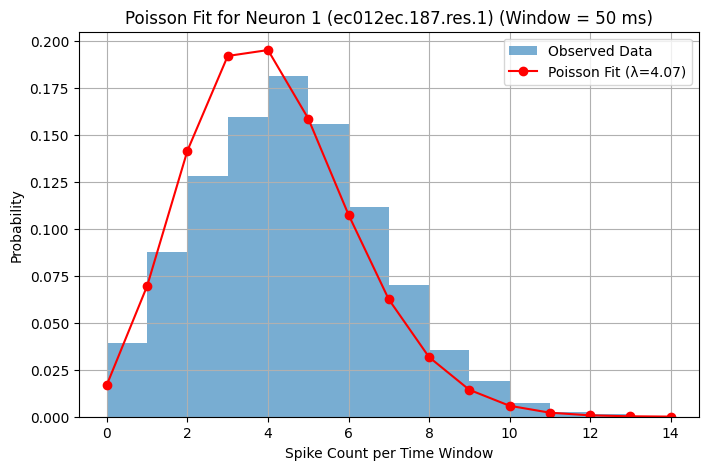

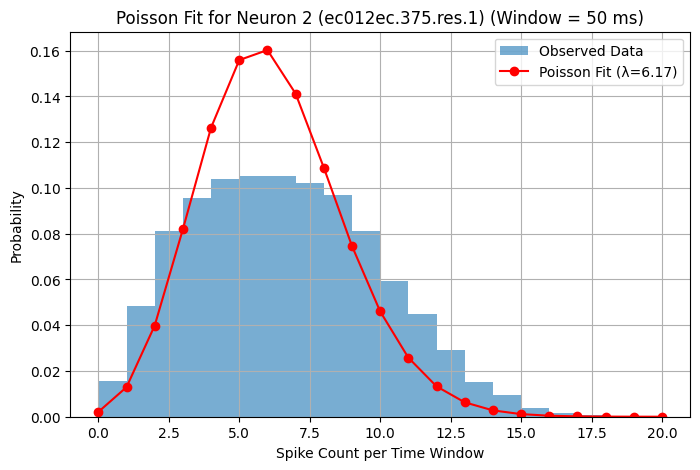

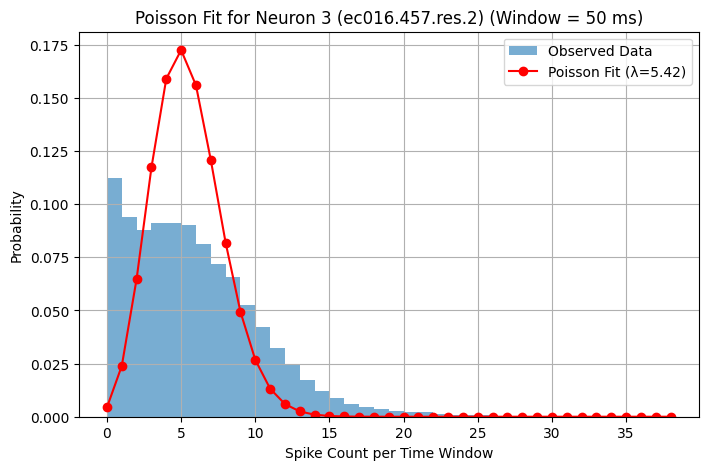

In [10]:
import matplotlib.pyplot as plt

def plot_spike_distribution(spike_counts, lambda_hat, neuron_name):
    """
    Plots histogram of observed spike counts and the fitted Poisson distribution.

    Parameters:
    - spike_counts (array): Observed spike counts per time window.
    - lambda_hat (float): Estimated Poisson rate parameter.
    - neuron_name (str): Neuron identifier.
    """
    plt.figure(figsize=(8, 5))

    # Histogram of actual spike counts
    plt.hist(spike_counts, bins=range(int(max(spike_counts)) + 1), density=True, alpha=0.6, label="Observed Data")

    # Poisson theoretical distribution
    x = np.arange(0, max(spike_counts) + 1)
    poisson_pmf = poisson.pmf(x, lambda_hat)
    plt.plot(x, poisson_pmf, 'ro-', label=f"Poisson Fit (λ={lambda_hat:.2f})")

    # Labels and title
    plt.xlabel("Spike Count per Time Window")
    plt.ylabel("Probability")
    plt.title(f"Poisson Fit for {neuron_name} (Window = {window_size} ms)")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Plot for each neuron
for neuron, counts in spike_counts_per_neuron.items():
    plot_spike_distribution(counts, poisson_params[neuron], neuron)


# Results + Analysis for Poisson

**File 1: ec012ec.187.res.1**
The distribution closely follows the Poisson pattern. This is evidenced by a Fano factor of 1.2

**File 2: ec012ec.375.res.1**
While the distribution doesn't fit as well as the first file, I would still say that this follows a Poisson distribution. The Fano factor is 1.75

**File 3: ec016.457.res.2**
This distribution does not follow Poisson. The Fano factor is 3.44


# Exponential Distribution

Next, we'll fit the data to an exponential distribution. We will calculate ISI values that we will use instead of the previously calculated time intervales

In [11]:
def compute_isi(spike_times):
    """
    Computes inter-spike intervals (ISI).

    Parameters:
    - spike_times (array): Array of spike times in milliseconds.

    Returns:
    - isi_values (array): Inter-spike interval values in milliseconds.
    """
    isi_values = np.diff(spike_times)  # Compute time differences
    return isi_values

# Compute ISI for each neuron
isi_data = {}
for neuron, df in spike_data.items():
    isi_data[neuron] = compute_isi(df["Time (ms)"].values)

# Show a few ISI samples
for neuron, isi_values in isi_data.items():
    print(f"First 10 ISI values for {neuron}: {isi_values[:10]}")


First 10 ISI values for Neuron 1 (ec012ec.187.res.1): [11.45 15.35 17.4   4.25 21.15 27.95 14.05  2.9  32.5   8.15]
First 10 ISI values for Neuron 2 (ec012ec.375.res.1): [ 6.75 11.9   8.9   4.45  3.45  3.75  6.85  9.2   8.9  34.2 ]
First 10 ISI values for Neuron 3 (ec016.457.res.2): [ 2.2   3.2   3.3   1.15 11.65  3.6   1.55  1.05  2.65  1.1 ]


Next, we will compute lambda for each neuron and compare it to the sample mean.

If the data is truly exponentially distributed, then lambda ~= 1/mean(ISI)

In [15]:
from scipy.stats import expon

def fit_exponential_mle(isi_values):
    """
    Fits an Exponential distribution using Maximum Likelihood Estimation (MLE).

    Parameters:
    - isi_values (array): Inter-spike intervals in milliseconds.

    Returns:
    - lambda_hat (float): Estimated rate parameter (1 / mean ISI).
    """
    lambda_hat = 1 / np.mean(isi_values)  # Exponential MLE estimate
    return lambda_hat

# Compute MLE Exponential parameter for each neuron
exponential_params = {}
for neuron, isi_values in isi_data.items():
    exponential_params[neuron] = fit_exponential_mle(isi_values)

# Print estimated Exponential parameters
for neuron, lambda_hat in exponential_params.items():
    print(f"Estimated lambda (Exponential rate) for {neuron}: {lambda_hat:.5f}")

print()

# Compare sample mean of ISI with estimated λ
for neuron, isi_values in isi_data.items():
    sample_mean = np.mean(isi_values)
    lambda_hat = exponential_params[neuron]
    print(f"{neuron}: Sample Mean ISI = {sample_mean:.5f}, Estimated 1/λ = {1/lambda_hat:.5f}")


Estimated lambda (Exponential rate) for Neuron 1 (ec012ec.187.res.1): 0.08131
Estimated lambda (Exponential rate) for Neuron 2 (ec012ec.375.res.1): 0.12337
Estimated lambda (Exponential rate) for Neuron 3 (ec016.457.res.2): 0.10847

Neuron 1 (ec012ec.187.res.1): Sample Mean ISI = 12.29867, Estimated 1/λ = 12.29867
Neuron 2 (ec012ec.375.res.1): Sample Mean ISI = 8.10576, Estimated 1/λ = 8.10576
Neuron 3 (ec016.457.res.2): Sample Mean ISI = 9.21887, Estimated 1/λ = 9.21887


We will then plot the expected fit

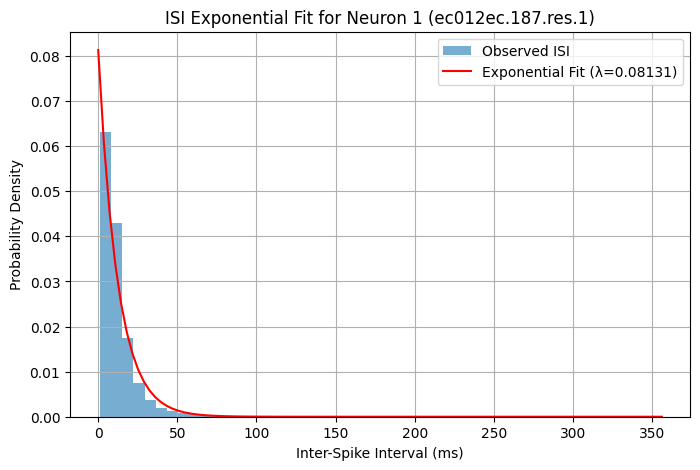

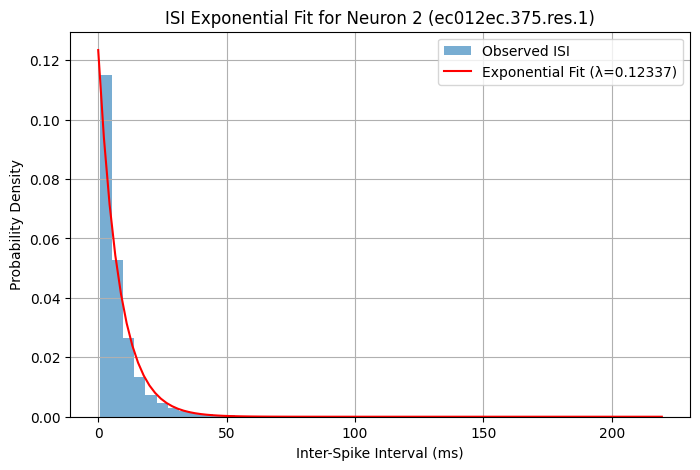

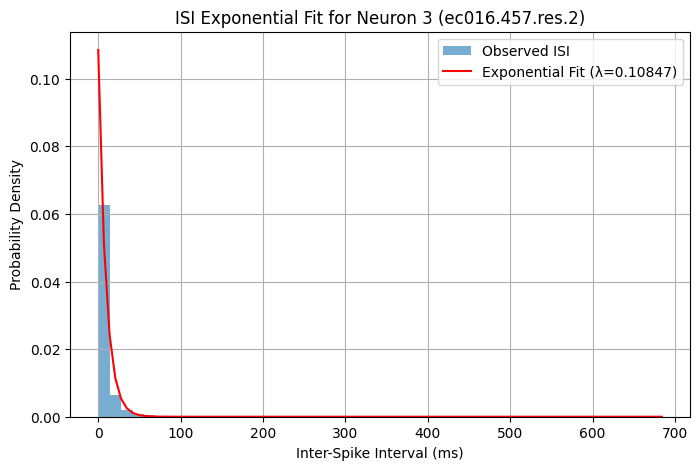

In [16]:
import matplotlib.pyplot as plt

def plot_isi_distribution(isi_values, lambda_hat, neuron_name):
    """
    Plots histogram of observed ISI values and the fitted Exponential distribution.

    Parameters:
    - isi_values (array): Observed inter-spike intervals in milliseconds.
    - lambda_hat (float): Estimated Exponential rate parameter.
    - neuron_name (str): Neuron identifier.
    """
    plt.figure(figsize=(8, 5))

    # Histogram of actual ISI values
    plt.hist(isi_values, bins=50, density=True, alpha=0.6, label="Observed ISI")

    # Exponential theoretical distribution
    x = np.linspace(0, max(isi_values), 100)
    exp_pdf = lambda_hat * np.exp(-lambda_hat * x)
    plt.plot(x, exp_pdf, 'r-', label=f"Exponential Fit (λ={lambda_hat:.5f})")

    # Labels and title
    plt.xlabel("Inter-Spike Interval (ms)")
    plt.ylabel("Probability Density")
    plt.title(f"ISI Exponential Fit for {neuron_name}")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Plot for each neuron
for neuron, isi_values in isi_data.items():
    plot_isi_distribution(isi_values, exponential_params[neuron], neuron)


# Results + Analysis - Exponential

All three of the graphs closely follow the exponential distribution. This means that the neuron's spiking behavior follows a Poisson process.

In [17]:
# Print summary of findings
print("Poisson Process Analysis (Spike Counts Per Window)")
for neuron in spike_counts_per_neuron.keys():
    lambda_poisson = poisson_params[neuron]
    fano_factor = fano_factors[neuron]
    print(f"{neuron}: Estimated λ = {lambda_poisson:.2f}, Fano Factor = {fano_factor:.2f}")

print("\nExponential Fit Analysis (Inter-Spike Intervals)")
for neuron in isi_data.keys():
    lambda_exponential = exponential_params[neuron]
    sample_mean_isi = np.mean(isi_data[neuron])
    print(f"{neuron}: Estimated λ = {lambda_exponential:.5f}, Sample Mean ISI = {sample_mean_isi:.5f}, 1/λ = {1/lambda_exponential:.5f}")


🔹 Poisson Process Analysis (Spike Counts Per Window)
Neuron 1 (ec012ec.187.res.1): Estimated λ = 4.07, Fano Factor = 1.20
Neuron 2 (ec012ec.375.res.1): Estimated λ = 6.17, Fano Factor = 1.75
Neuron 3 (ec016.457.res.2): Estimated λ = 5.42, Fano Factor = 3.44

🔹 Exponential Fit Analysis (Inter-Spike Intervals)
Neuron 1 (ec012ec.187.res.1): Estimated λ = 0.08131, Sample Mean ISI = 12.29867, 1/λ = 12.29867
Neuron 2 (ec012ec.375.res.1): Estimated λ = 0.12337, Sample Mean ISI = 8.10576, 1/λ = 8.10576
Neuron 3 (ec016.457.res.2): Estimated λ = 0.10847, Sample Mean ISI = 9.21887, 1/λ = 9.21887


## Interpretation of Findings

### **1. Poisson Distribution Fit (Spike Counts per Window)**
- If the **Fano Factor ≈ 1**, the spike counts are well-modeled by a Poisson distribution.
- If **Fano Factor > 1**, the neuron exhibits **more variability (overdispersion)** than a Poisson process, suggesting **bursty firing**.
- If **Fano Factor < 1**, the neuron spikes **more regularly than expected**, indicating rhythmic firing.

### **2. Exponential Distribution Fit (Inter-Spike Intervals)**
- If `1/λ` **matches the sample mean ISI**, the ISI distribution is well-fitted by an **Exponential distribution**, supporting the Poisson assumption.
- If there is **deviation**, it may indicate:
  - **Refractory periods**: The neuron is **less likely to fire soon after a spike**.
  - **Bursts of activity**: Groups of spikes occur close together, disrupting the **Poisson assumption**.

### **3. Do These Neurons Follow a Poisson Process?**
- If both **Poisson (Fano Factor ≈ 1) and Exponential (λ ≈ 1/mean(ISI))** conditions hold, then the neuron is likely **Poisson-distributed**.
- Two of the neurons had a Fano factor ~= 1, but one of them had a Fano factor of 3
- However, all three neurons passed the exponential distribution test
- At least two of the nuerons for sure follow the Poisson distribution. I'm not sure about the third one though since it did not follow the Poisson on the initial testing

### **4. Possible Biological Explanations**
- **Hippocampal neurons** (our dataset) may not be purely Poisson due to:
  - **Neural network dependencies** (inhibitory/excitatory interactions).
  - **Behavioral state of the animal** (e.g., awake vs. asleep firing).
  - **External stimuli affecting spike timing**.

---
